In [129]:
# Import necessary libraries for image processing and visualization
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


In [131]:
# Define class mappings for reclassification
class_mapping_lr_to_hr = {
    10: [4], 11: [4], 12: [4], 20: [4], 30: [4], 40: [4],
    60: [2], 61: [2], 70: [2], 80: [2], 90: [2], 100: [2],
    110: [8], 130: [8],
    180: [3],
    190: [5],
    200: [6], 201: [6], 202: [6],
    210: [1],
    220: [7]
}

class_mapping_hr_to_hr_aligned = {
    1: [1], 2: [2], 4: [3], 5: [4], 7: [5], 8: [6], 9: [7], 11: [8]
}

class_names_and_colors = {
    1: ('Water', '#419bdf'),
    2: ('Forest', '#397d49'),
    3: ('Wetland', '#7a87c6'),
    4: ('Agriculture', '#e49635'),
    5: ('Settlement', '#c4281b'),
    6: ('Bare area', '#a59b8f'),
    7: ('Snow/Ice', '#a8ebff'),
    8: ('Rangeland', '#e3e2c3')
}

# Define the input and output directories for LR and HR images
lr_folder = r"C:\Users\Israa\Desktop\Land cover maps\LR"
hr_folder = r"C:\Users\Israa\Desktop\Land cover maps\HR"
reproject_lr_folder = r"C:\Users\Israa\Desktop\Land cover maps\Code1 outputs\Reprojected_LR"
reproject_hr_folder = r"C:\Users\Israa\Desktop\Land cover maps\Code1 outputs\Reprojected_HR"
aligned_lr_folder = r"C:\Users\Israa\Desktop\Land cover maps\Code1 outputs\Aligned_LR"
aligned_hr_folder = r"C:\Users\Israa\Desktop\Land cover maps\Code1 outputs\Aligned_HR"

# Ensure the output folders exist
os.makedirs(reproject_lr_folder, exist_ok=True)
os.makedirs(reproject_hr_folder, exist_ok=True)
os.makedirs(aligned_lr_folder, exist_ok=True)
os.makedirs(aligned_hr_folder, exist_ok=True)


In [133]:
# Process images for each year
for year in range(2017, 2023):
    print(f"Processing images for the year {year}...")

    # Define file paths for LR and HR images
    lr_filename = f"{year} LR.tif"
    hr_filename = f"{year} HR.tif"
    lr_path = os.path.join(lr_folder, lr_filename)
    hr_path = os.path.join(hr_folder, hr_filename)

    # Define output paths for reprojected LR and HR images
    reprojected_lr_path = os.path.join(reproject_lr_folder, f"{year}_LR_reprojected.tif")
    reprojected_hr_path = os.path.join(reproject_hr_folder, f"{year}_HR_reprojected.tif")
    aligned_lr_path = os.path.join(aligned_lr_folder, f"{year}_LR_aligned_reclassified.tif")
    aligned_hr_path = os.path.join(aligned_hr_folder, f"{year}_HR_aligned_reclassified.tif")

    # Step 5: Reproject and resample LR image to EPSG:32632 (UTM zone 32N) and 10m resolution
    with rasterio.open(lr_path) as lr_src:
        transform, width, height = calculate_default_transform(
            lr_src.crs, 'EPSG:32632', lr_src.width, lr_src.height, *lr_src.bounds, resolution=10)
        lr_meta = lr_src.meta.copy()
        lr_meta.update({
            'crs': 'EPSG:32632',
            'transform': transform,
            'width': width,
            'height': height,
            'dtype': rasterio.uint8
        })
        
        lr_data = np.empty((height, width), dtype=rasterio.uint8)
        reproject(
            source=rasterio.band(lr_src, 1),
            destination=lr_data,
            src_transform=lr_src.transform,
            src_crs=lr_src.crs,
            dst_transform=transform,
            dst_crs='EPSG:32632',
            resampling=Resampling.nearest
        )
    
    # Save the reprojected LR image
    with rasterio.open(reprojected_lr_path, 'w', **lr_meta) as dst:
        dst.write(lr_data, 1)

    # Reclassify the LR image, excluding classes 0, 120, 150
    reclassified_lr = np.zeros_like(lr_data)
    for old_class, new_classes in class_mapping_lr_to_hr.items():
        reclassified_lr[np.isin(lr_data, old_class)] = new_classes[0]
    reclassified_lr[np.isin(lr_data, [0, 120, 150])] = 0

    # Save the reclassified LR image
    with rasterio.open(aligned_lr_path, 'w', **lr_meta) as dst:
        dst.write(reclassified_lr, 1)

    # Step 6: Reproject and resample HR image to EPSG:32632 (UTM zone 32N) and 10m resolution
    with rasterio.open(hr_path) as hr_src:
        transform, width, height = calculate_default_transform(
            hr_src.crs, 'EPSG:32632', hr_src.width, hr_src.height, *hr_src.bounds, resolution=10)
        hr_meta = hr_src.meta.copy()
        hr_meta.update({
            'crs': 'EPSG:32632',
            'transform': transform,
            'width': width,
            'height': height,
            'dtype': rasterio.uint8
        })
        
        hr_data = np.empty((height, width), dtype=rasterio.uint8)
        reproject(
            source=rasterio.band(hr_src, 1),
            destination=hr_data,
            src_transform=hr_src.transform,
            src_crs=hr_src.crs,
            dst_transform=transform,
            dst_crs='EPSG:32632',
            resampling=Resampling.nearest
        )
    
    # Save the reprojected HR image
    with rasterio.open(reprojected_hr_path, 'w', **hr_meta) as dst:
        dst.write(hr_data, 1)

    # Reclassify the HR image, excluding class 10
    reclassified_hr = np.zeros_like(hr_data)
    for old_class, new_classes in class_mapping_hr_to_hr_aligned.items():
        reclassified_hr[np.isin(hr_data, old_class)] = new_classes[0]
    reclassified_hr[hr_data == 10] = 0

    # Save the reclassified HR image
    with rasterio.open(aligned_hr_path, 'w', **hr_meta) as dst:
        dst.write(reclassified_hr, 1)


Processing images for the year 2017...
Processing images for the year 2018...
Processing images for the year 2019...
Processing images for the year 2020...
Processing images for the year 2021...
Processing images for the year 2022...


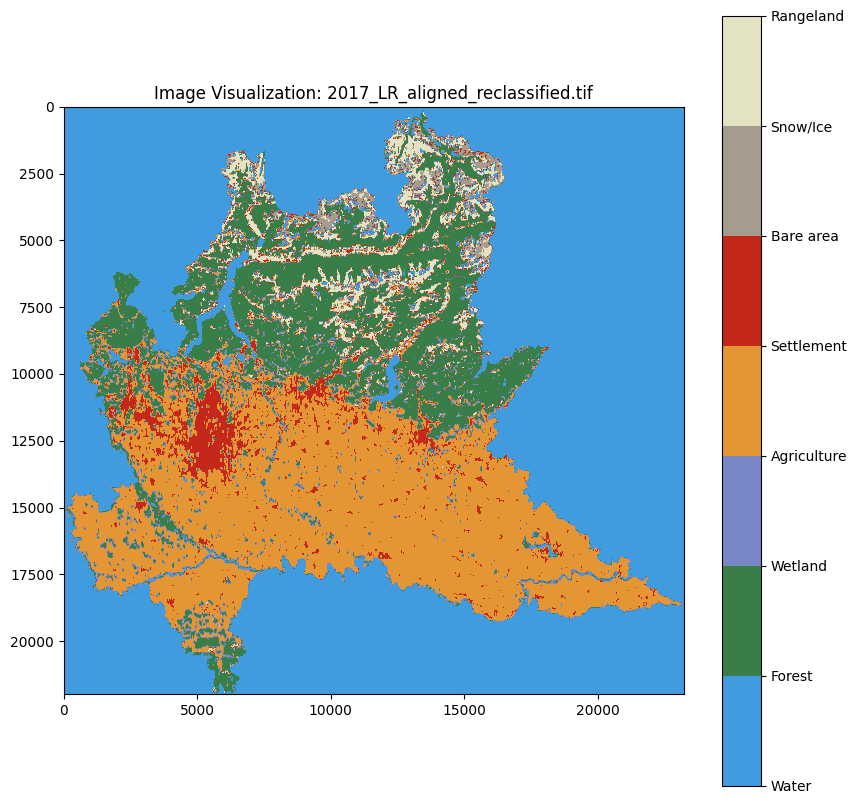

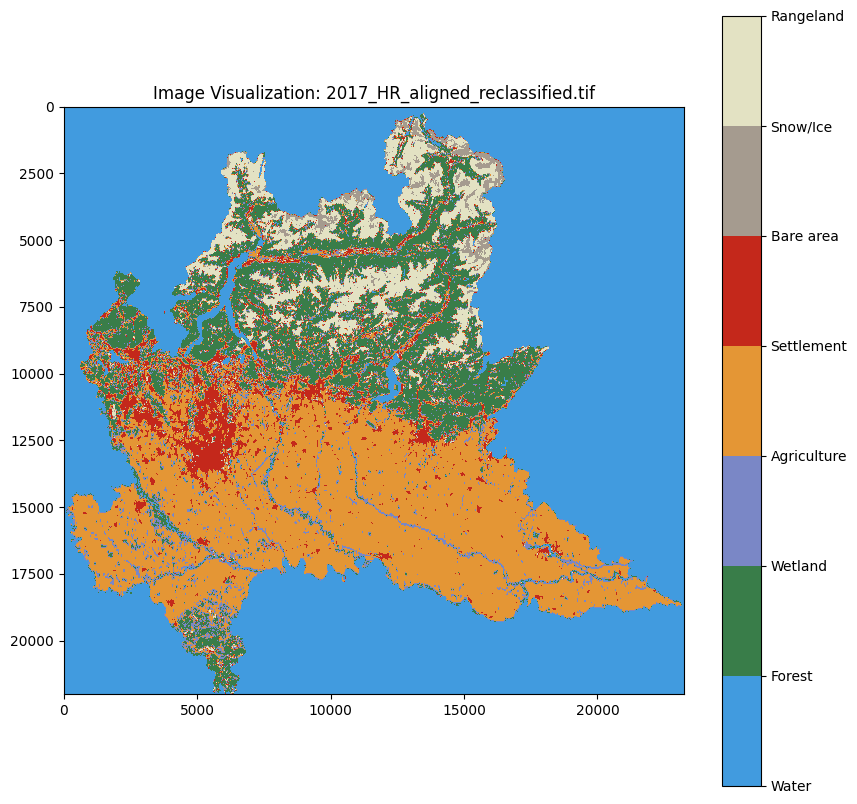

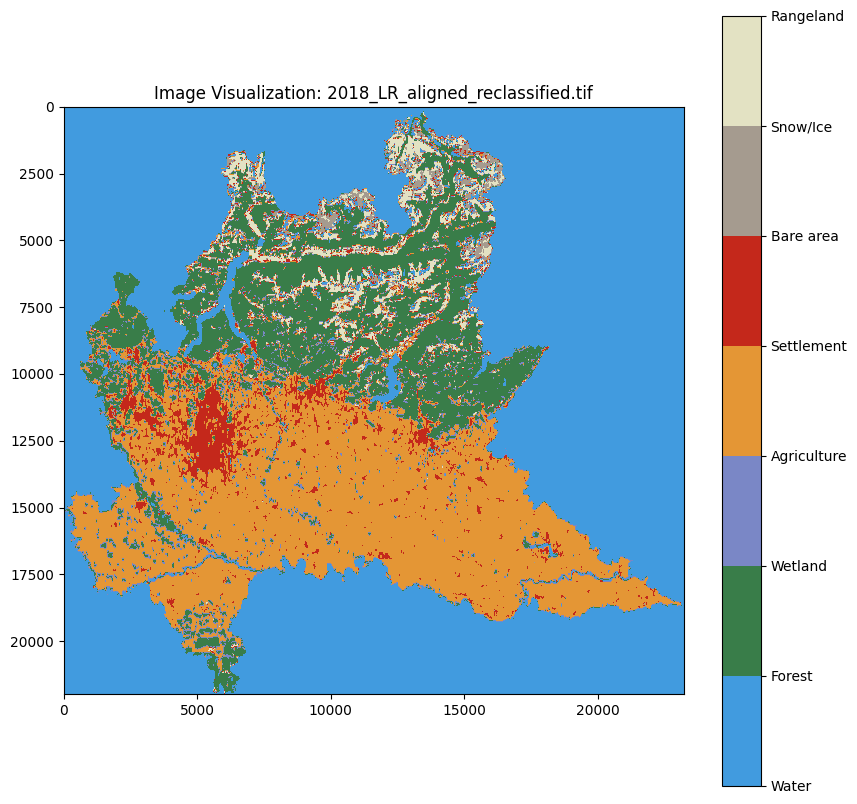

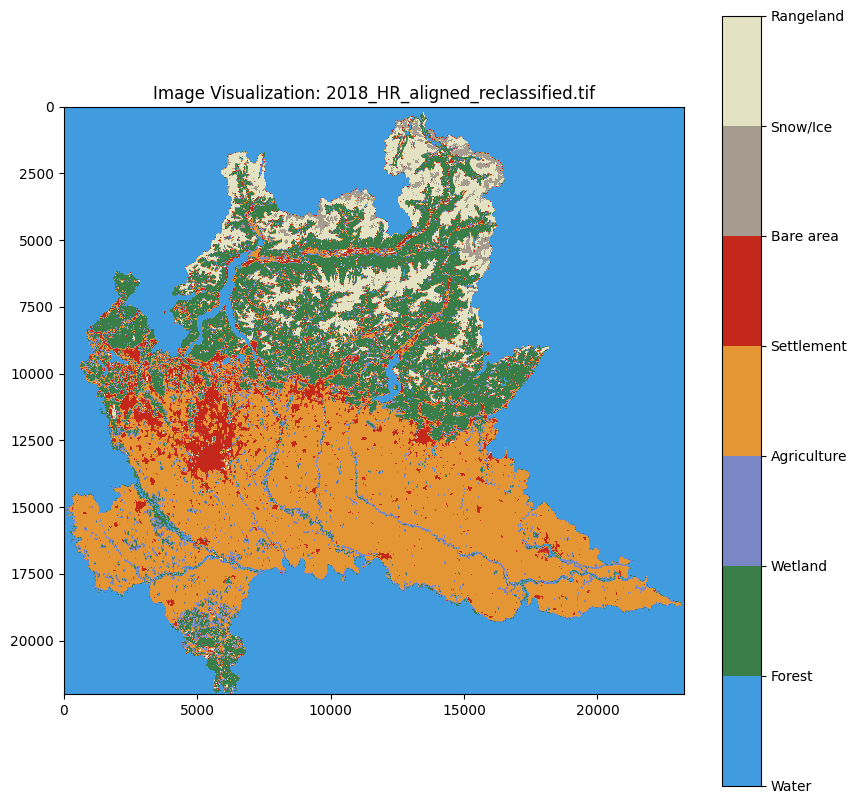

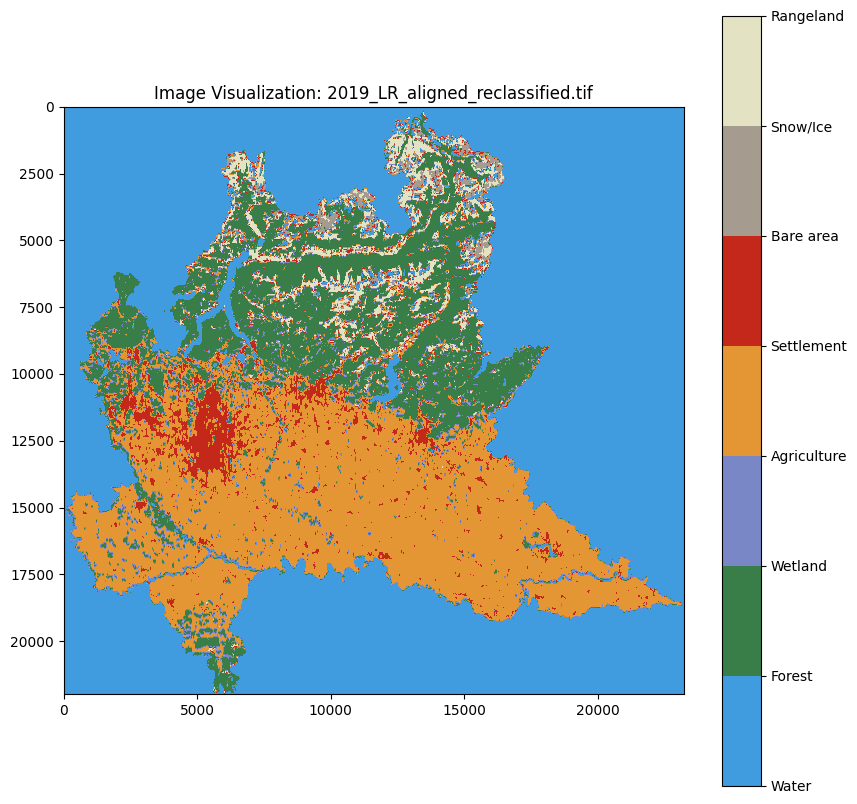

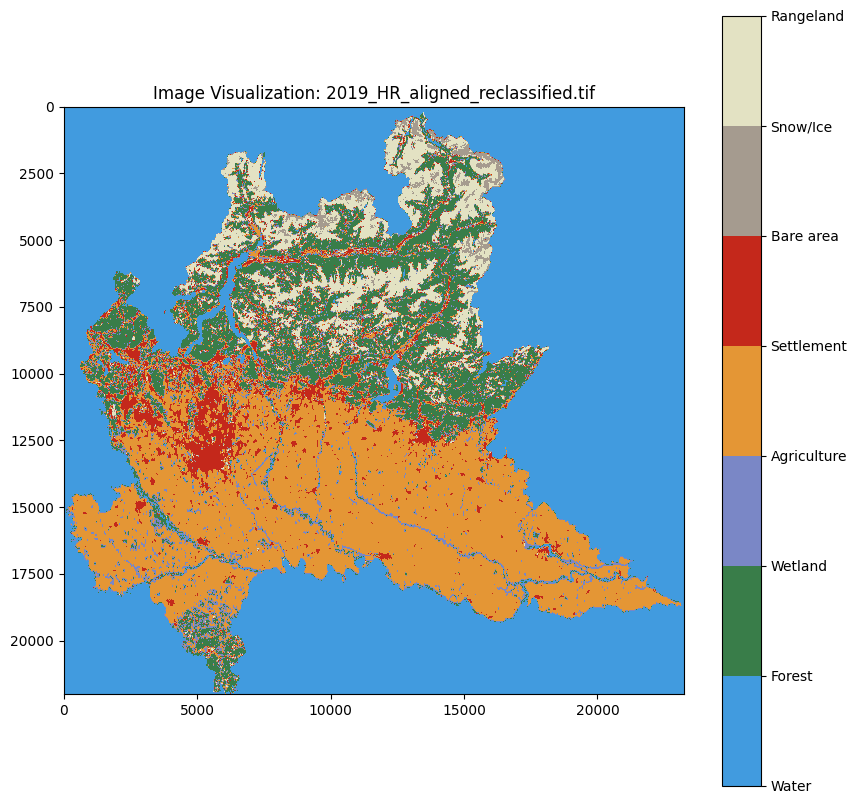

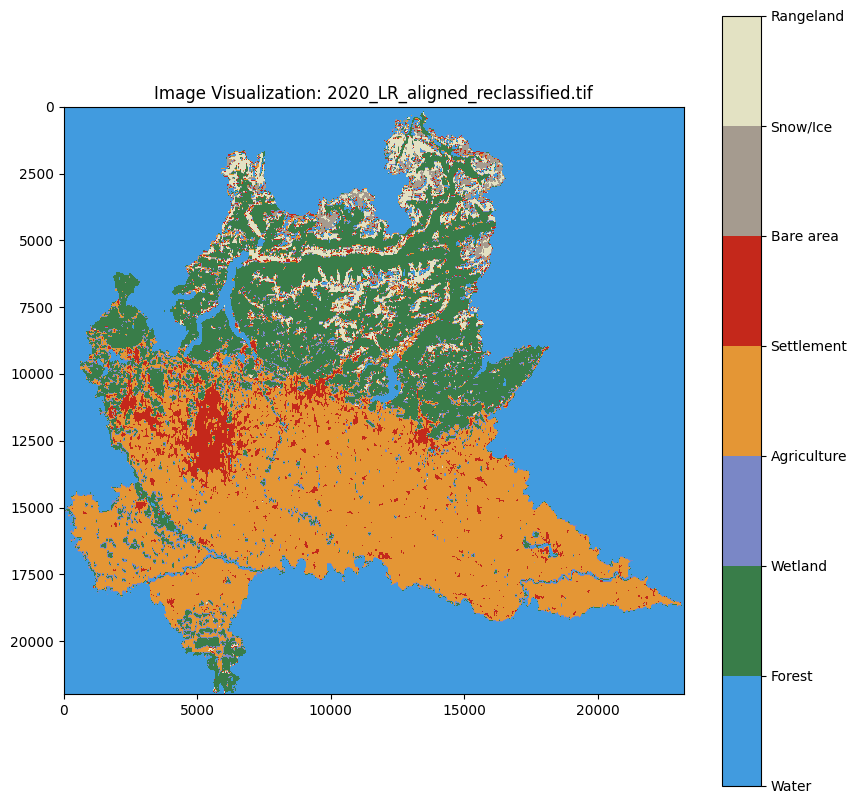

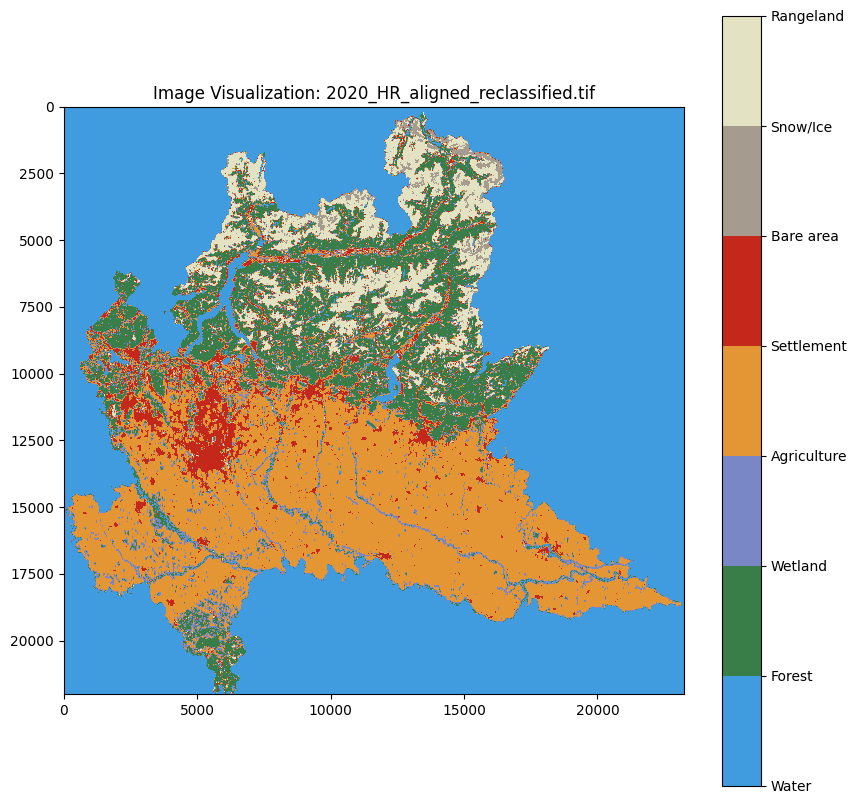

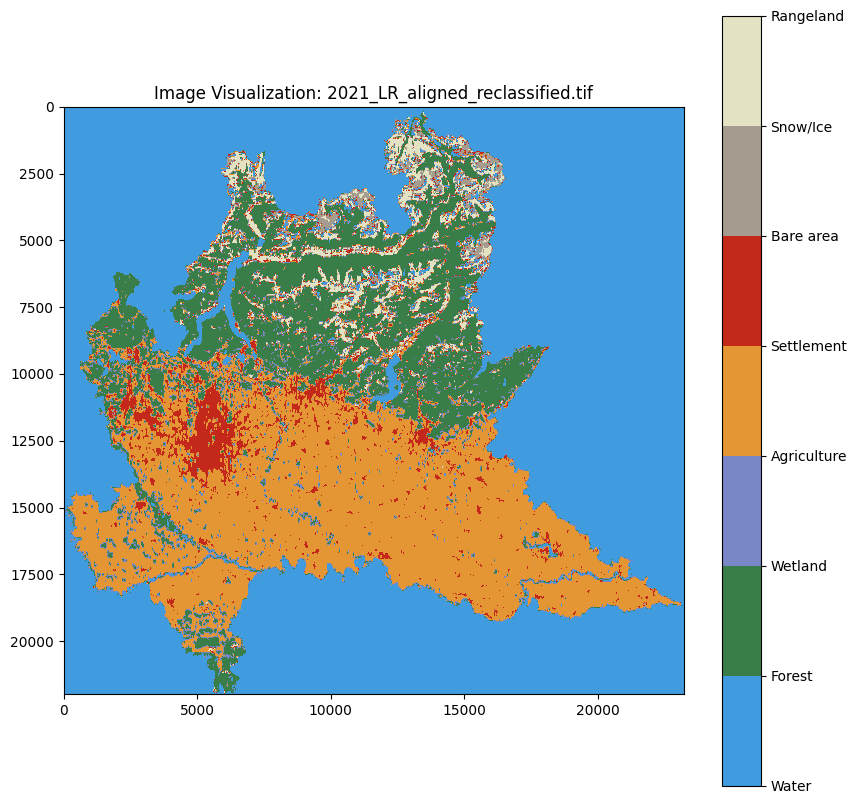

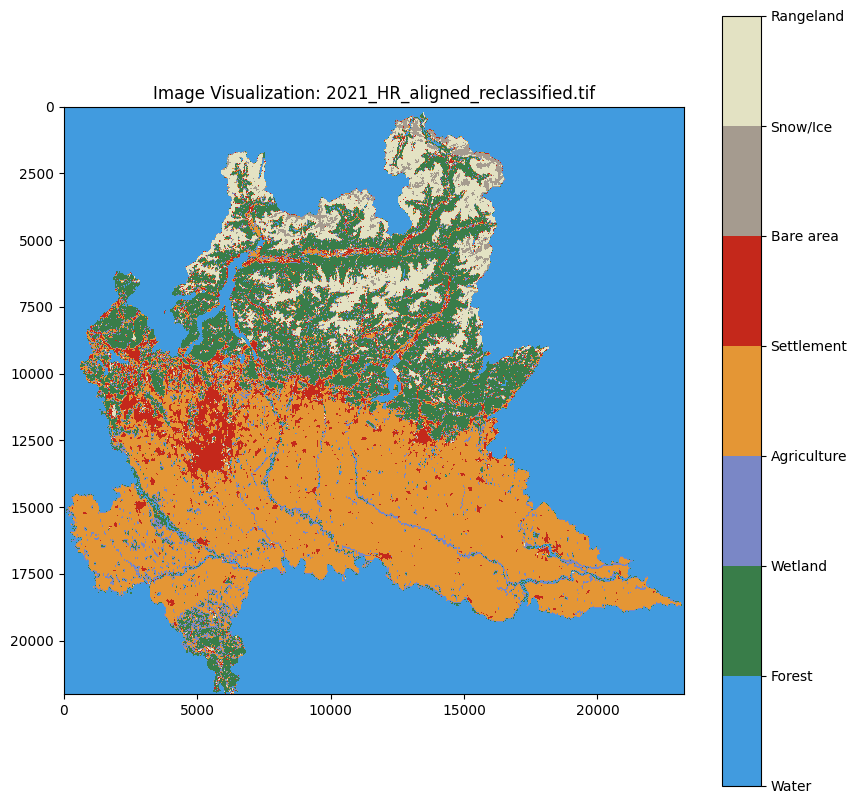

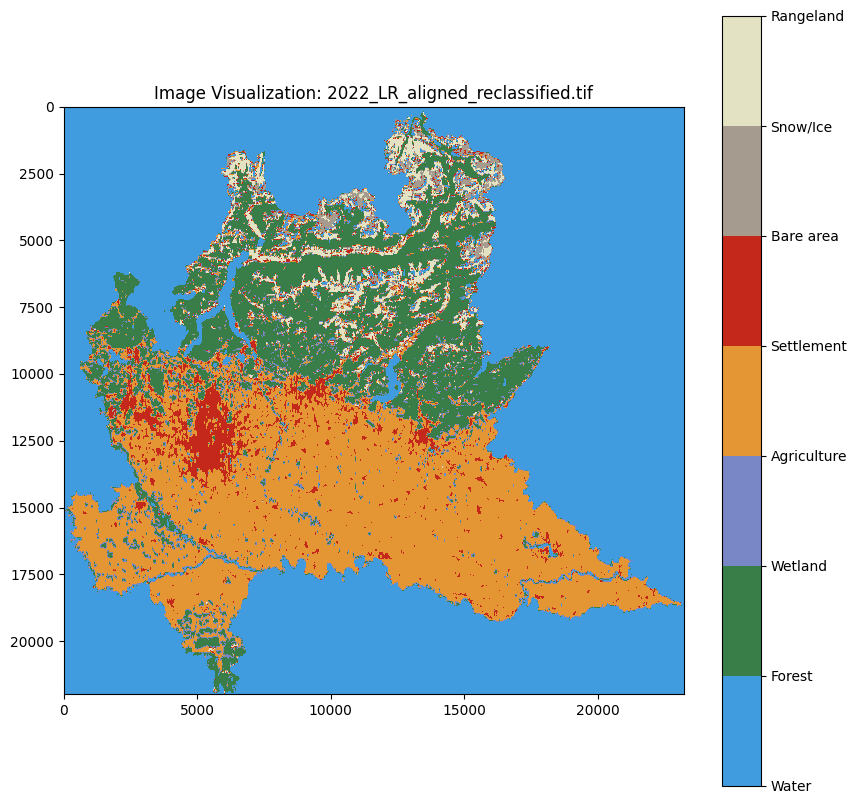

MemoryError: Unable to allocate 1.90 GiB for an array with shape (22012, 23228) and data type float32

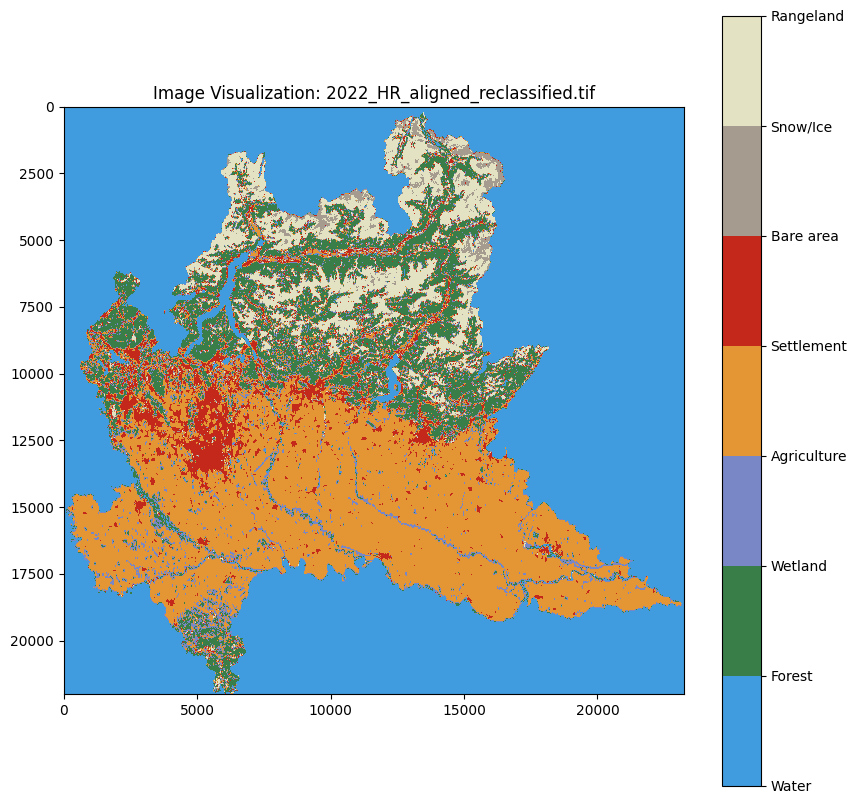

In [135]:
# Define a function to visualize and save the images, excluding 'Unknown' class (0)
def visualize_image(image_path, class_names_and_colors):
    # Exclude 'Unknown' class
    valid_classes = {k: v for k, v in class_names_and_colors.items() if k != 0}
    
    with rasterio.open(image_path) as src:
        data = src.read(1)
        colors = [color for name, color in valid_classes.values()]
        cmap = ListedColormap(colors)
        bounds = list(valid_classes.keys())
        norm = BoundaryNorm(bounds, cmap.N, clip=True)

        plt.figure(figsize=(10, 10))
        img = plt.imshow(data, cmap=cmap, norm=norm)
        plt.title(f'Image Visualization: {os.path.basename(image_path)}')
        cbar = plt.colorbar(img, ticks=bounds)
        cbar.ax.set_yticklabels([valid_classes[i][0] for i in bounds])
        plt.savefig(image_path.replace('.tif', '_visualized.png'))
        plt.show()

# Visualize reclassified LR and HR images
for year in range(2017, 2023):
    reclassified_lr_path = os.path.join(aligned_lr_folder, f"{year}_LR_aligned_reclassified.tif")
    reclassified_hr_path = os.path.join(aligned_hr_folder, f"{year}_HR_aligned_reclassified.tif")
    visualize_image(reclassified_lr_path, class_names_and_colors)
    visualize_image(reclassified_hr_path, class_names_and_colors)
